Failure rate =  0.0317527375581802
Fidelity =  0.9467796669152124
Minimun Fidelity = 0.9364945248836396


100%|██████████| 50/50 [00:00<00:00, 748.55it/s]
/Users/Copains123/anaconda3/lib/python3.11/site-packages/matplotlib/cbook.py:1699: ComplexWarning: Casting complex values to real discards the imaginary part
  return math.isfinite(val)
/Users/Copains123/anaconda3/lib/python3.11/site-packages/matplotlib/collections.py:194: ComplexWarning: Casting complex values to real discards the imaginary part
  offsets = np.asanyarray(offsets, float)


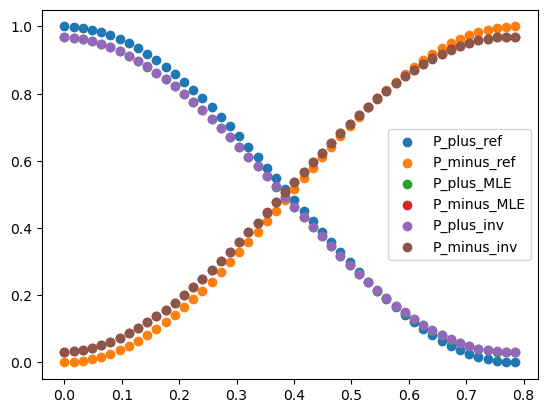

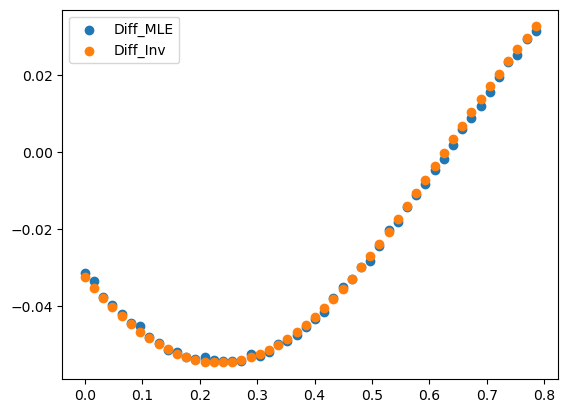

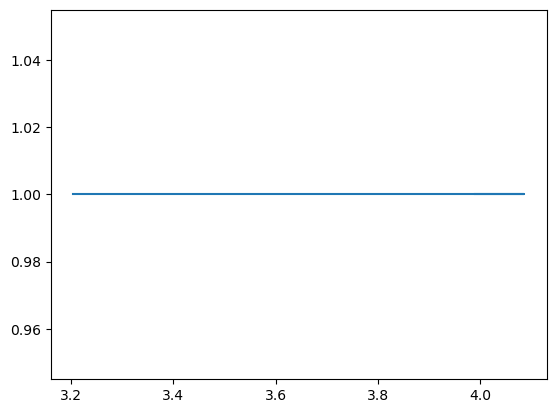

In [11]:
#### Linking the failure rate to the visibility ####
import numpy as np 
import scipy.optimize as sp
import functools as ft 
import QPE_Noise as qp_n
import random
import matplotlib.pyplot as plt
from tqdm import tqdm
import os 
import QPE_Function as qpef

working_dir_data = r'/Users/Copains123/Documents/Code_Thèse/QST_GHZ_aqtime=600.0s_20240426180903 2'
filenames = [r'QST_GHZ_aqtime=600.0s_20240426180903']
for index, file in enumerate(filenames):
    os.chdir(f'{working_dir_data}//{file}')
    with open('dm_no_correction.npy','rb') as f:
        density_matrix = (np.load(f))


def Real_Measurement(M:int,Meas_X:float):
    # Function to create the array of measurement parity 
    # M is the number of measurement 
    # Meas_X is the result of the measurement operators
    X = []
  
    Proba = (1+abs(Meas_X))/2
    
    if (Meas_X > 0):
        for i in range(int(M*Proba)):
            X.append(0)
        for i in range (int(M*(1-Proba))):
            X.append(1)
    if (Meas_X < 0):
        for i in range(int(M*(1-Proba))):
            X.append(0)
        for i in range (int(M*(Proba))):
            X.append(1)
    random.shuffle(X)
    return(np.array(X))
    
def Parity(Y:float,V:float,N:int):
    
    '''
    Function to claculate the parity probability P_even, P_odd
    Y : The linear fucntion of thetas
    V : The visibility
    N : The number of measurment (Here the number of qubits)
    '''
    return((1 + V*np.cos(N*Y))/(2),(1 + -V*np.cos(N*Y))/(2))

def Maximun_Likelihood(Y:float,V:float,N:int,X):
    
    '''
    Function to calculate the maximun likelihood function of the parity distribution
    Y : The linear fucntion of thetas
    V : The visibility
    N : The number of measurment (Here the number of qubits)
    X : The measurement result. 
    '''

    Dis_prob = (1 + V*np.cos(N*Y-X*np.pi))/(2)
    return(-np.sum(np.log(Dis_prob)))

def Prob(Meas_X:float,V:float):
    
    '''
    Function to calculate the linear fucntion but by inverting the fucntion
    V : The visibility
    Meax_X : Result from the XXXX Measurement
    '''
    
    if (Meas_X > 0):
        P= (1+Meas_X)/2
        return((np.arccos((2*P-1)/(V))/N))
    if (Meas_X < 0):
        P = (1-Meas_X)/2
        return((np.arccos((-2*P+1)/(V))/N))

sigma_x = np.array([[0,1],[1,0]])
sigma_z = np.matrix([[1,0],[0,-1]])
sigma_y = np.matrix([[0,-1j],[1j,0]])
Id = np.matrix([[1,0],[0,1]])
Id_8 = np.identity(16)
N = 4

varying_angle_1 = np.linspace(0,np.pi,num = 50)
varying_angle_2 = np.pi/4
varying_angle_3 = np.pi/2
varying_angle_4 = np.pi/3


# Measurement list
List_of_Meas = [ft.reduce(np.kron,(sigma_x,sigma_x,sigma_x,sigma_x)),-ft.reduce(np.kron,(sigma_y,sigma_y,sigma_x,sigma_x)),
                -ft.reduce(np.kron,(sigma_x,sigma_y,sigma_y,sigma_x)),-ft.reduce(np.kron,(sigma_x,sigma_x,sigma_y,sigma_y)),
                -ft.reduce(np.kron,(sigma_y,sigma_x,sigma_x,sigma_y))]

#State
bell=(np.array([1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0])+np.array([0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1]))/np.sqrt(2)
rho = (np.array(np.outer(bell, np.transpose(np.conjugate(bell)))))
noise = qp_n.Noise(rho)

#noise.verify_K_One(phase_damping) to verify it's still a kraus operator
phase_damping = noise.phase_damping_Kraus_operators(0)
amplitude_damping = noise.amplitude_damping_Kraus_operators(0)
depolarising = noise.depolarising_Kraus_operators(0)
dephasing = noise.dephasing_Kraus_operators(0)

#Noise List
Noise_type = [phase_damping,amplitude_damping,depolarising,dephasing]

#Noise List
Rho_Noise = qp_n.apply_noise(noise.state, 4,Noise_type, 4)
#White noise
p = 0.937
Rho_Noise_White = p*rho + (1-p)*Id_8/16

Rho_Exp = density_matrix

# Failure rate
F = (1 - 1/5*(np.sum([np.trace(Rho_Exp@List_of_Meas[i]) for i in range(len(List_of_Meas))])))/2
print('Failure rate = ', np.real(F))

# Fidelity 
Fidelity = qp_n.fid(Rho_Exp,rho)
print('Fidelity = ',np.real(Fidelity))
print('Minimun Fidelity =', (np.real(2*(1-F)-1)))

#Creating different list 
Theta_Inv, P_plus_Inv, P_minus_Inv, P_plus_MLE, P_minus_MLE = ([] for _ in range(5))
P_plus_Ref, P_minus_Ref, Total_angle, Diff_Inv, Diff_MLE,Theta_MLE = ([] for _ in range(6))
P_MLE = []
for i in tqdm(range(len(varying_angle_1))):
    # Angle per qubit
        angle = np.array([0,0,0,varying_angle_1[i]])
        
        # Average angle
        Total_angle.append(sum(angle)/N)
        Measuremt = np.trace(qp_n.apply_angle(Rho_Exp,angle)@ft.reduce(np.kron,(sigma_x,sigma_x,sigma_x,sigma_x)))
        
        #Guess
        Y_init = np.pi
        
        #Measurement result
        X = Real_Measurement(1000,Measuremt)
        
        #Measurement angle
        First_Guess = sp.minimize(Maximun_Likelihood,Y_init,args=(np.real((1-F)),N,X),method = 'Nelder-Mead').x[0]
        Theta_MLE.append(sp.minimize(Maximun_Likelihood,First_Guess,args=(np.real((1-F)),N,X)).x[0])
        Theta_Inv.append(Prob(Measuremt,np.real((1-F))))
        
        #Theta_Bristol = sp.minimize(Maximun_Likelihood,Y_init,args=(np.real(4*(1-F)-3),N,X)).x
        
        # List of probability recalculate using diffrent method
        P_plus_Ref.append(Parity(Total_angle[i],np.real(1),N)[0])
        P_minus_Ref.append(Parity(Total_angle[i],np.real(1),N)[1])
        P_plus_MLE.append(Parity(Theta_MLE[i],np.real((1-F)),N)[0])
        P_minus_MLE.append(Parity(Theta_MLE[i],np.real((1-F)),N)[1])
        P_plus_Inv.append(Parity(Theta_Inv[i],np.real((1-F)),N)[0])
        P_minus_Inv.append(Parity(Theta_Inv[i],np.real((1-F)),N)[1])
        P_MLE.append(Parity(Theta_MLE[i],np.real((1-F)),N)[0]+Parity(Theta_MLE[i],np.real((1-F)),N)[1])
        
        #Precision of the estimators
        Diff_MLE.append(np.cos(N*Theta_MLE[i]) - (np.cos(N*Total_angle[i])))
        Diff_Inv.append(np.cos(N*Theta_Inv[i]) - (np.cos(N*Total_angle[i])))

# Ploting the data
for label, data in [('P_plus_ref', P_plus_Ref), ('P_minus_ref', P_minus_Ref), 
                    ('P_plus_MLE', P_plus_MLE), ('P_minus_MLE', P_minus_MLE), 
                    ('P_plus_inv', P_plus_Inv), ('P_minus_inv', P_minus_Inv)]:
    plt.scatter(Total_angle, data, label=label)
plt.legend()
plt.show()

for label, data2 in [('Diff_MLE',Diff_MLE),('Diff_Inv',Diff_Inv)]:
    plt.scatter(Total_angle,data2,label =label)
    
plt.legend()
plt.show()

plt.plot(Theta_MLE,P_MLE)

/var/folders/lc/_rcknr0d06s21ps17qjmr02h0000gp/T/ipykernel_75035/3228854693.py:12: RuntimeWarning: invalid value encountered in scalar divide
  return(((V**2)*(4**2)*(np.sin(4*theta)**2))/(1-(V**2)*(np.cos(4*theta)**2)))
/var/folders/lc/_rcknr0d06s21ps17qjmr02h0000gp/T/ipykernel_75035/3228854693.py:12: RuntimeWarning: divide by zero encountered in scalar divide
  return(((V**2)*(4**2)*(np.sin(4*theta)**2))/(1-(V**2)*(np.cos(4*theta)**2)))
/Users/Copains123/anaconda3/lib/python3.11/site-packages/matplotlib/cbook.py:1345: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


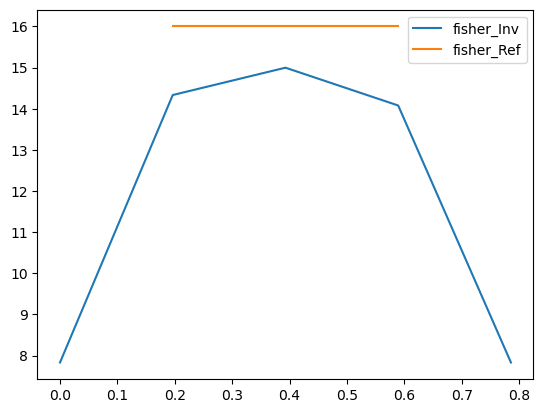

In [ ]:
#Calculating the Fisher information

import numpy as np 
import matplotlib.pyplot as plt

fisher_Inv = []
fisher_MLE = []
fisher_Ref = []
fisher_matrix = []

def fisher(V,theta):
    return(((V**2)*(4**2)*(np.sin(4*theta)**2))/(1-(V**2)*(np.cos(4*theta)**2)))

for i in range(len(Theta_Inv)):
    fisher_Inv.append(fisher(1-F,Theta_Inv[i]))
    fisher_Ref.append(fisher(1,Total_angle[i]))
    fisher_matrix.append(fisher(1-F,Theta_Inv[i])*np.ones((4,4)))
    
for label,data in [('fisher_Inv',fisher_Inv),('fisher_Ref',fisher_Ref)]:
    plt.plot(Total_angle,data,label=label)
plt.legend()
plt.show()


    


In [11]:
np.exp(1j*np.pi/2)

(6.123233995736766e-17+1j)

In [41]:
W = np.ones((4,4))*1/16
alpha = np.matrix([1/4,1/4,1/4,1/4])
alphaT = np.transpose(alpha)

(np.trace(fisher_matrix[0]@W))/np.trace(fisher_matrix[0])                                     

(0.25-6.062248408576644e-33j)

In [42]:
alphaT@alpha

matrix([[0.0625, 0.0625, 0.0625, 0.0625],
        [0.0625, 0.0625, 0.0625, 0.0625],
        [0.0625, 0.0625, 0.0625, 0.0625],
        [0.0625, 0.0625, 0.0625, 0.0625]])

In [112]:
################ CALCULATING THE NUMBER OF REQUIRE SAMPLE AND THE PRIVACY ############

import numpy.linalg as l 
import numpy as np
from tqdm import tqdm


def H_prime(Number_of_qubit : int ,Position_angle : int, w : list):
    
    Id = np.identity(2)
    H = Id 
    i = 1
    sigma_z = np.matrix([[1,0],[0,-1]])
    
    if Position_angle == 1:
        H = w[Position_angle-1]*sigma_z
        for i in range(Number_of_qubit-1):
            H = np.kron(H,Id)
    else :
        for i in range(Number_of_qubit-1):    
            if i+2 == Position_angle:
                H = np.kron(H,w[Position_angle-1]*sigma_z)
            else :
                H = np.kron(H,Id)
    return(H)



bell=(np.array([1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0])+np.array([0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1]))/np.sqrt(2)
rho = (np.array(np.outer(bell, np.transpose(np.conjugate(bell)))))

p = 0.9
Rho_Exp = density_matrix
Rho_Noise_White = p*rho + (1-p)*Id_8/16

List_of_Meas = [ft.reduce(np.kron,(sigma_x,sigma_x,sigma_x,sigma_x)),-ft.reduce(np.kron,(sigma_y,sigma_y,sigma_x,sigma_x)),
                -ft.reduce(np.kron,(sigma_x,sigma_y,sigma_y,sigma_x)),-ft.reduce(np.kron,(sigma_x,sigma_x,sigma_y,sigma_y)),
                -ft.reduce(np.kron,(sigma_y,sigma_x,sigma_x,sigma_y))]

F = (1 - 1/5*(np.sum([np.trace(Rho_Noise_White@List_of_Meas[i]) for i in range(len(List_of_Meas))])))/2

N_test = np.linspace(1,10**7,num = 10**7)

m = N_test/((N**4)*np.log(N))

c = ((3/2)*(1-(np.log(0.01)/np.log(N))))/m

Confidence_level = 1-(N**(1-2*m*c/3))

H_m = H_prime(4,2,[1,1,1,1]) 
H_v = H_prime(4,1,[1,1,1,1]) 

F_min = np.real(1-2*np.sqrt(c)/4 - 8*F)

def Privacy( H1, H2, rho, F = None, F_min = None):
    sigma_z = np.matrix([[1,0],[0,-1]])
    M = l.norm((H1 - H2)@rho - rho@(H1 - H2),np.inf)
    
    if F is not None and F_min is not None:
        Privacy_F = 8*l.norm(sigma_z,np.inf)*np.sqrt(1-np.real(F))        
        Privacy_F_Min = 8*l.norm(sigma_z,np.inf)*np.sqrt(1-F_min)
        return(M,Privacy_F,Privacy_F_Min)
    
    if F is not None:
        Privacy_F = 8*l.norm(sigma_z,np.inf)*np.sqrt(1-np.real(F))
        return(M,Privacy_F) 
        
    if F_min is not None:
        Privacy_F_Min = 8*l.norm(sigma_z,np.inf)*np.sqrt(1-F_min)
        return(Privacy_F_Min)
    
    
################## EXPERIMENTAL DENSITY MATRIX ##########################


import os 
import numpy as np

working_data = r'/Users/Copains123/Documents/Code_Thèse/QST_GHZ_aqtime=600.0s_20240426180903 2'
filenames = [r'QST_GHZ_aqtime=15.0s_20240426113453']
for index, file in enumerate(filenames):
    os.chdir(f"{working_data}//{file}")
    with open('dm_no_correction.npy','rb') as f:
        density = np.load(f)
    

NameError: name 'density_matrix' is not defined

/var/folders/lc/_rcknr0d06s21ps17qjmr02h0000gp/T/ipykernel_975/2324784387.py:10: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  color = cm.get_cmap('viridis', len(p))
100%|██████████| 4/4 [00:00<00:00, 15.70it/s]


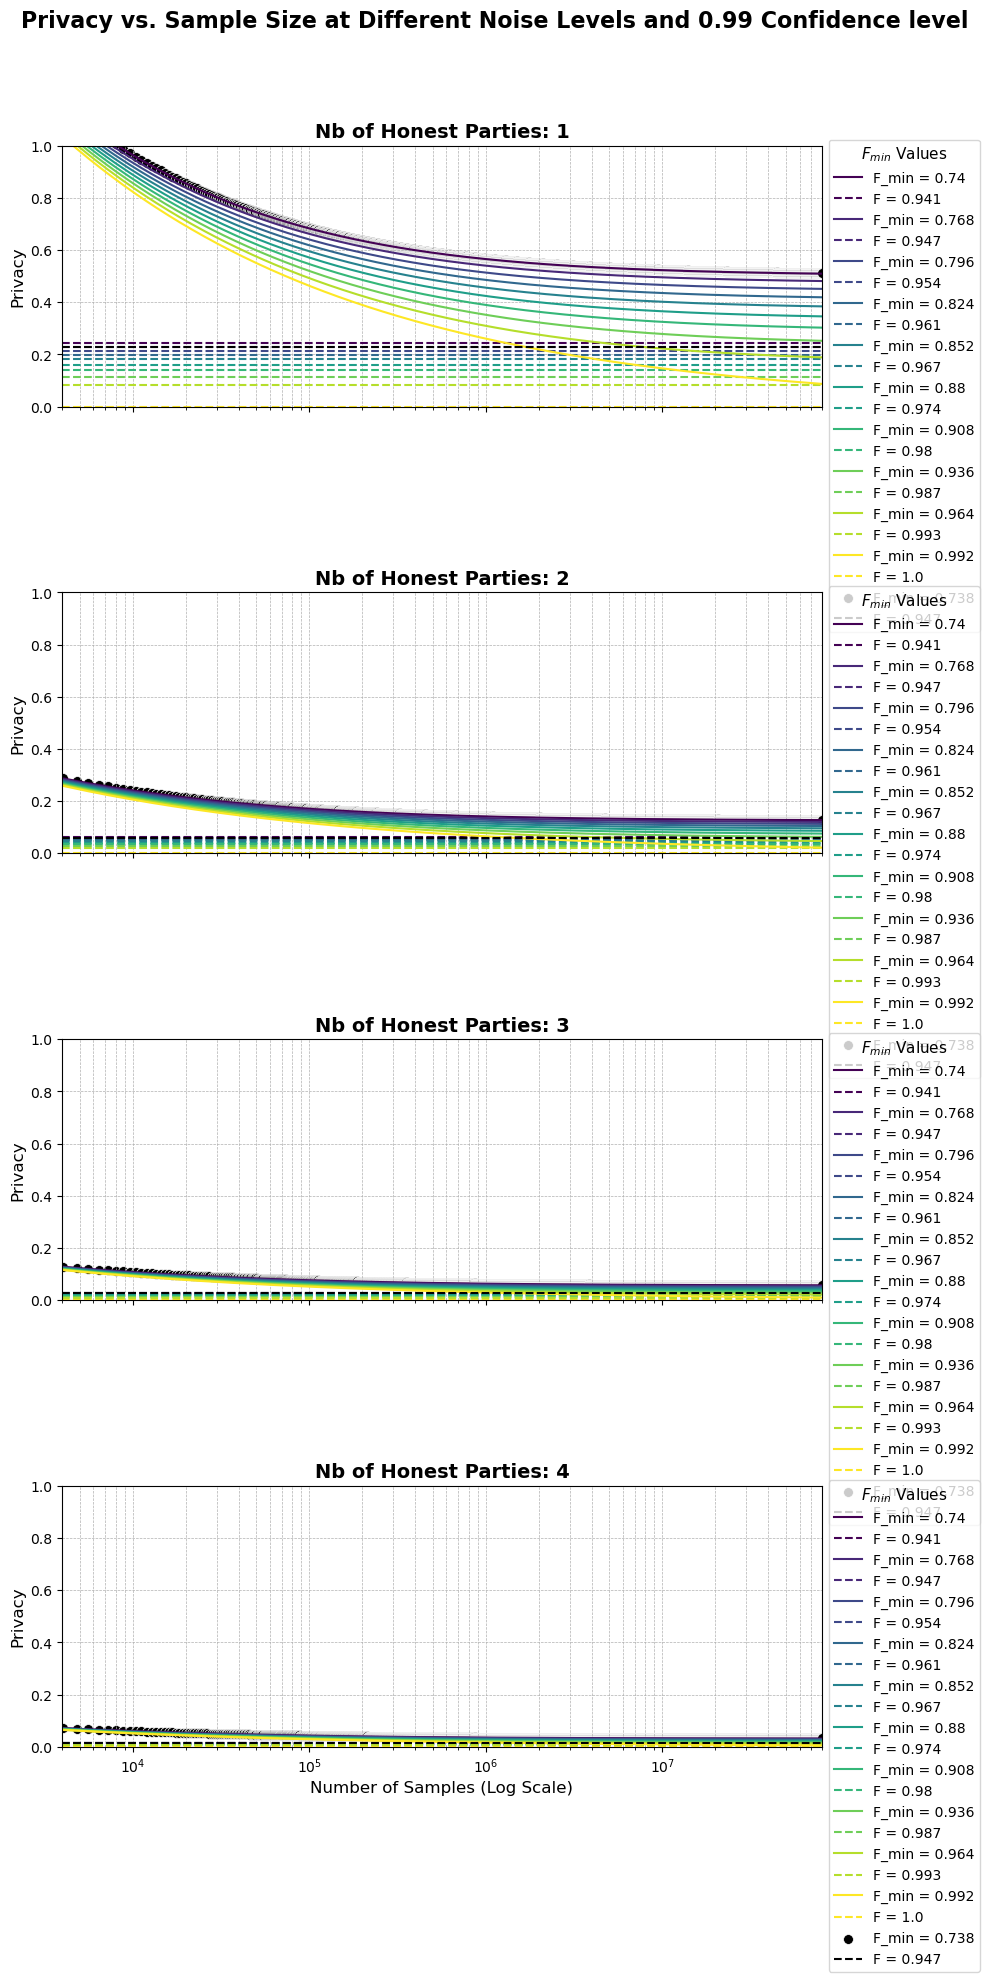

In [53]:
from tqdm import tqdm
import matplotlib.cm as cm
import numpy as np
import matplotlib.pyplot as plt

# Constants and matrix definitions
N = 4
N_test = np.linspace(1, 10**7, num=10**5)
p = np.linspace(0.937, 1, num=10)
color = cm.get_cmap('viridis', len(p))

# Calculate parameters for plotting
m = N_test / ((N**4) * np.log(N))
c = ((3 / 2) * (1 - (np.log(0.01) / np.log(N)))) / m
n_H = np.arange(5)

# Set up the figure and subplots
fig, axes = plt.subplots(len(n_H) - 1, 1, figsize=(10, 20), sharex=True)
fig.suptitle('Privacy vs. Sample Size at Different Noise Levels and 0.99 Confidence level', fontsize=16, fontweight='bold')

# Loop through the number of honest parties
for j in tqdm(range(len(n_H) - 1)):
    for i in range(len(p)):
        # Construct the noisy state
        Rho_Noise_White = p[i] * rho + (1 - p[i]) * Id_8 / 16  
        
        # Calculate Fidelity and Privacy parameters
        F = (1 - 1 / 5 * (np.sum([np.trace(Rho_Noise_White @ List_of_Meas[k]) for k in range(len(List_of_Meas))])))/2
        F_min = np.real(1 - 2 * np.sqrt(c) / 4 - 8 * F)
        Fidelity = np.round(qp_n.fid(Rho_Noise_White, rho), 3)
        P_min = (24 / n_H[j + 1]**2) * (np.sqrt(2 * np.sqrt(c) / N + 2 * N * F)) / 24
        P = (24 / n_H[j + 1]**2) * (np.sqrt(1-Fidelity)) / 24
        # Plotting in the current subplot
        axes[j].plot(8 * N_test, P_min, label=f'F_min = {np.max(np.round(np.real(F_min), 3))}', color=color(i))
        axes[j].axhline(P, label = f'F = {np.round(np.real(Fidelity),3)}',color = color(i), linestyle = '--')
        
    Rho_Exp = density_matrix
    # Calculate Fidelity and Privacy parameters
    F = (1 - 1 / 5 * (np.sum([np.trace(Rho_Exp @ List_of_Meas[k]) for k in range(len(List_of_Meas))])))/2
    F_min = np.real(1 - 2 * np.sqrt(c) / 4 - 8 * F)
    Fidelity = np.round(qp_n.fid(Rho_Exp, rho), 3)
    P_min = (24 / n_H[j + 1]**2) * (np.sqrt(2 * np.sqrt(c) / N + 2 * N * F)) / 24
    P = (24 / n_H[j + 1]**2) * (np.sqrt(1-Fidelity)) / 24
        
    axes[j].scatter(8 * N_test, P_min, label=f'F_min = {np.max(np.round(np.real(F_min), 3))}', color='k', s=50, marker='o', edgecolor='w', linewidth=0.5)
    axes[j].axhline(P, label = f'F = {np.round(np.real(Fidelity),3)}',color = 'k', linestyle = '--')

    # Customization for each subplot
    axes[j].set_xlim(4 * 10**3, max(8 * N_test))
    axes[j].set_xscale('log')
    axes[j].set_ylabel('Privacy', fontsize=12)
    axes[j].set_ylim(0, 1)
    axes[j].set_title(f'Nb of Honest Parties: {n_H[j + 1]}', fontsize=14, fontweight='bold')
    axes[j].grid(True, which='both', linestyle='--', linewidth=0.5)

    # Adding legend for each subplot
    axes[j].legend(title='$F_{min}$ Values', loc='upper left', bbox_to_anchor=(1, 1.05), fontsize=10, title_fontsize=11)

# Adding the common x-label
axes[-1].set_xlabel('Number of Samples (Log Scale)', fontsize=12)

# Tight layout to avoid overlap
plt.tight_layout(rect=[0, 0.03, 1, 0.95])  # Leave space for the main title
plt.show()


/var/folders/lc/_rcknr0d06s21ps17qjmr02h0000gp/T/ipykernel_975/4165362558.py:25: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  color = cm.get_cmap('viridis', len(F_min))
  0%|          | 0/10 [00:00<?, ?it/s]/var/folders/lc/_rcknr0d06s21ps17qjmr02h0000gp/T/ipykernel_975/4165362558.py:30: RuntimeWarning: divide by zero encountered in log
  m = ((3/2)*(1-(np.log(1-Confidence_level)/np.log(N))))/c
/var/folders/lc/_rcknr0d06s21ps17qjmr02h0000gp/T/ipykernel_975/4165362558.py:30: RuntimeWarning: invalid value encountered in divide
  m = ((3/2)*(1-(np.log(1-Confidence_level)/np.log(N))))/c
/var/folders/lc/_rcknr0d06s21ps17qjmr02h0000gp/T/ipykernel_975/4165362558.py:31: RuntimeWarning: invalid value encountered in multiply
  N_test = m*((N**4)*np.log(N))
100%|██████████| 10/10 [00:00<00:00, 21.03it/s]


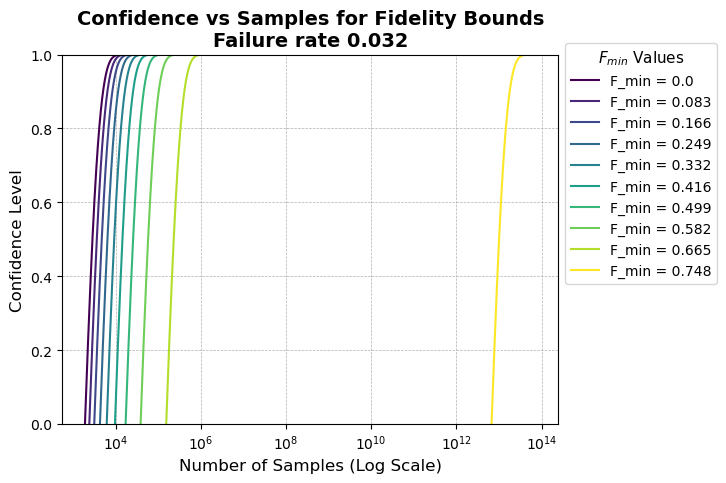

In [260]:
from tqdm import tqdm
import matplotlib.cm as cm
import os
import numpy as np
import matplotlib.pyplot as plt
import functools as ft

bell=(np.array([1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0])+np.array([0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1]))/np.sqrt(2)
rho = (np.array(np.outer(bell, np.transpose(np.conjugate(bell)))))
Confidence_level = np.linspace(0,1,num = 1000000)
p = 0.937
sigma_x = np.array([[0,1],[1,0]])
sigma_z = np.matrix([[1,0],[0,-1]])
sigma_y = np.matrix([[0,-1j],[1j,0]])
Id = np.matrix([[1,0],[0,1]])
Id_8 = np.identity(16)

List_of_Meas = [ft.reduce(np.kron,(sigma_x,sigma_x,sigma_x,sigma_x)),-ft.reduce(np.kron,(sigma_y,sigma_y,sigma_x,sigma_x)),
                -ft.reduce(np.kron,(sigma_x,sigma_y,sigma_y,sigma_x)),-ft.reduce(np.kron,(sigma_x,sigma_x,sigma_y,sigma_y)),
                -ft.reduce(np.kron,(sigma_y,sigma_x,sigma_x,sigma_y))]

Rho_Noise_White = p*rho + (1-p)*Id_8/16  
F = (1 - 1/5*(np.sum([np.trace(Rho_Noise_White@List_of_Meas[i]) for i in range(len(List_of_Meas))])))/2
F_min = np.linspace(0,(1-2.0001*N*F),num=10)
color = cm.get_cmap('viridis', len(F_min))
N =4

for i in tqdm(range(len(F_min))):
    c = (N*(1-F_min[i]-2.0000001*N*F)/2)**2
    m = ((3/2)*(1-(np.log(1-Confidence_level)/np.log(N))))/c
    N_test = m*((N**4)*np.log(N))
    plt.plot(8*N_test,Confidence_level,label = f'F_min = {np.max(np.round(np.real(F_min[i]),3))}',color = color(i))
    

plt.title(f'Confidence vs Samples for Fidelity Bounds\nFailure rate {np.round(np.real(F),3)}', fontsize=14, fontweight='bold')
plt.xscale('log')
plt.xlabel('Number of Samples (Log Scale)', fontsize=12)
plt.ylabel('Confidence Level', fontsize=12)
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.ylim(0,1)
# Adding a legend and adjusting its position for better visibility
plt.legend(title='$F_{min}$ Values', loc='upper left', bbox_to_anchor=(1, 1.05), fontsize=10, title_fontsize=11)

# Making layout tight to avoid overlapping elements
plt.show()




/var/folders/lc/_rcknr0d06s21ps17qjmr02h0000gp/T/ipykernel_975/4011189951.py:25: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  color = cm.get_cmap('viridis', len(F_min))
  0%|          | 0/10 [00:00<?, ?it/s]/var/folders/lc/_rcknr0d06s21ps17qjmr02h0000gp/T/ipykernel_975/4011189951.py:30: RuntimeWarning: divide by zero encountered in log
  m = ((3/2)*(1-(np.log(1-Confidence_level)/np.log(N))))/c
100%|██████████| 10/10 [00:00<00:00, 24.02it/s]


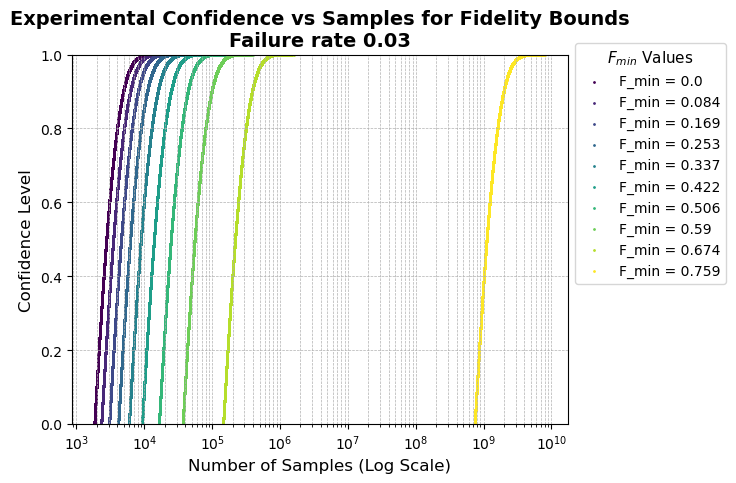

In [258]:
from tqdm import tqdm
import matplotlib.cm as cm
import os
import numpy as np
import matplotlib.pyplot as plt
import functools as ft

bell=(np.array([1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0])+np.array([0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1]))/np.sqrt(2)
rho = (np.array(np.outer(bell, np.transpose(np.conjugate(bell)))))
Confidence_level = np.linspace(0,1,num = 1000000)
sigma_x = np.array([[0,1],[1,0]])
sigma_z = np.matrix([[1,0],[0,-1]])
sigma_y = np.matrix([[0,-1j],[1j,0]])
Id = np.matrix([[1,0],[0,1]])
Id_8 = np.identity(16)

List_of_Meas = [ft.reduce(np.kron,(sigma_x,sigma_x,sigma_x,sigma_x)),-ft.reduce(np.kron,(sigma_y,sigma_y,sigma_x,sigma_x)),
                -ft.reduce(np.kron,(sigma_x,sigma_y,sigma_y,sigma_x)),-ft.reduce(np.kron,(sigma_x,sigma_x,sigma_y,sigma_y)),
                -ft.reduce(np.kron,(sigma_y,sigma_x,sigma_x,sigma_y))]

Rho_Exp = density_matrix
F = (1 - 1/5*(np.sum([np.trace(density_matrix@List_of_Meas[i]) for i in range(len(List_of_Meas))])))/2
F = 0.03
F_min = np.linspace(0,(1-2.01*N*F),num=10)
color = cm.get_cmap('viridis', len(F_min))
N =4

for i in tqdm(range(len(F_min))):
    c = (N*(1-F_min[i]-2*N*F)/2)**2
    m = ((3/2)*(1-(np.log(1-Confidence_level)/np.log(N))))/c
    N_test = m*((N**4)*np.log(N))
    plt.scatter(8*N_test,Confidence_level,label = f'F_min = {np.max(np.round(np.real(F_min[i]),3))}',color = color(i), s =1)

plt.title(f'Experimental Confidence vs Samples for Fidelity Bounds\nFailure rate {np.round(np.real(F),3)}', fontsize=14, fontweight='bold')
plt.xscale('log')
plt.xlabel('Number of Samples (Log Scale)', fontsize=12)
plt.ylabel('Confidence Level', fontsize=12)
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.ylim(0,1)
# Adding a legend and adjusting its position for better visibility
plt.legend(title='$F_{min}$ Values', loc='upper left', bbox_to_anchor=(1, 1.05), fontsize=10, title_fontsize=11)

# Making layout tight to avoid overlapping elements
plt.show()




(5.551115123125783e-17+0j)


/var/folders/lc/_rcknr0d06s21ps17qjmr02h0000gp/T/ipykernel_975/3689392260.py:21: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  color = cm.get_cmap('viridis', len(p))


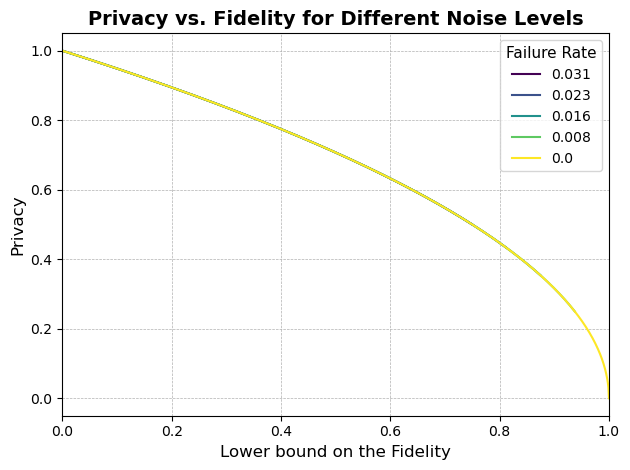

In [47]:
from tqdm import tqdm
import matplotlib.cm as cm
import os
import numpy as np
import matplotlib.pyplot as plt
import functools as ft

bell=(np.array([1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0])+np.array([0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1]))/np.sqrt(2)
rho = (np.array(np.outer(bell, np.transpose(np.conjugate(bell)))))
Confidence_level = np.linspace(1,0,num = 1000000)
sigma_x = np.array([[0,1],[1,0]])
sigma_z = np.matrix([[1,0],[0,-1]])
sigma_y = np.matrix([[0,-1j],[1j,0]])
Id = np.matrix([[1,0],[0,1]])
Id_8 = np.identity(16)

List_of_Meas = [ft.reduce(np.kron,(sigma_x,sigma_x,sigma_x,sigma_x)),-ft.reduce(np.kron,(sigma_y,sigma_y,sigma_x,sigma_x)),
                -ft.reduce(np.kron,(sigma_x,sigma_y,sigma_y,sigma_x)),-ft.reduce(np.kron,(sigma_x,sigma_x,sigma_y,sigma_y)),
                -ft.reduce(np.kron,(sigma_y,sigma_x,sigma_x,sigma_y))]
p = np.linspace(0.9375,1,num=5)
color = cm.get_cmap('viridis', len(p))
N =4
for j in range(len(p)):
    P_min =[]
    Rho_Noise_White = p[j]*rho + (1-p[j])*Id_8/16  
    F = (1 - 1/5*(np.sum([np.trace(Rho_Noise_White@List_of_Meas[i]) for i in range(len(List_of_Meas))])))/2
    F_min = np.linspace(0,1-2*N*F,num=1000)
    for i in range(len(F_min)):
        c = (N*(1-F_min[i]-8*F)/2)**2
        P_min.append((24)*(np.sqrt(2*np.sqrt(c)/N + 2*N*F))/24)
    plt.plot(F_min,P_min,label = f'{np.max(np.round(np.real(F),3))}',color = color(j))
    


print(F)
plt.title(f'Privacy vs. Fidelity for Different Noise Levels', fontsize=14, fontweight='bold')
plt.xlabel('Lower bound on the Fidelity', fontsize=12)
plt.ylabel('Privacy', fontsize=12)
plt.xlim(0, 1)
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.legend(title='Failure Rate', fontsize=10, loc='upper right', title_fontsize=11)

# Making layout tight to avoid overlapping elements
plt.tight_layout()
plt.show()



/var/folders/lc/_rcknr0d06s21ps17qjmr02h0000gp/T/ipykernel_975/2289811278.py:21: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  color = cm.get_cmap('viridis', len(p))


(0.0317527375581802+2.42861286636753e-18j)


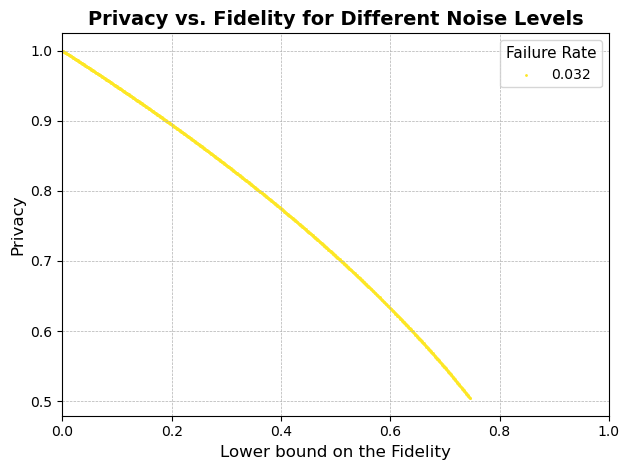

In [48]:
from tqdm import tqdm
import matplotlib.cm as cm
import os
import numpy as np
import matplotlib.pyplot as plt
import functools as ft

bell=(np.array([1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0])+np.array([0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1]))/np.sqrt(2)
rho = (np.array(np.outer(bell, np.transpose(np.conjugate(bell)))))
Confidence_level = np.linspace(1,0,num = 1000000)
sigma_x = np.array([[0,1],[1,0]])
sigma_z = np.matrix([[1,0],[0,-1]])
sigma_y = np.matrix([[0,-1j],[1j,0]])
Id = np.matrix([[1,0],[0,1]])
Id_8 = np.identity(16)

List_of_Meas = [ft.reduce(np.kron,(sigma_x,sigma_x,sigma_x,sigma_x)),-ft.reduce(np.kron,(sigma_y,sigma_y,sigma_x,sigma_x)),
                -ft.reduce(np.kron,(sigma_x,sigma_y,sigma_y,sigma_x)),-ft.reduce(np.kron,(sigma_x,sigma_x,sigma_y,sigma_y)),
                -ft.reduce(np.kron,(sigma_y,sigma_x,sigma_x,sigma_y))]

color = cm.get_cmap('viridis', len(p))
N =4
P_min =[]
Rho_Exp = density_matrix 
F = (1 - 1/5*(np.sum([np.trace(Rho_Exp@List_of_Meas[i]) for i in range(len(List_of_Meas))])))/2
F_min = np.linspace(0,1-2*N*F,num=1000)
for i in range(len(F_min)):
    c = (N*(1-F_min[i]-8*F)/2)**2
    P_min.append((24)*(np.sqrt(2*np.sqrt(c)/N + 2*N*F))/24)
plt.scatter(F_min,P_min,label = f'{np.max(np.round(np.real(F),3))}',color = color(j), s=1)
    


print(F)
plt.title(f'Privacy vs. Fidelity for Different Noise Levels', fontsize=14, fontweight='bold')
plt.xlabel('Lower bound on the Fidelity', fontsize=12)
plt.ylabel('Privacy', fontsize=12)
plt.xlim(0, 1)
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.legend(title='Failure Rate', fontsize=10, loc='upper right', title_fontsize=11)

# Making layout tight to avoid overlapping elements
plt.tight_layout()
plt.show()



/var/folders/lc/_rcknr0d06s21ps17qjmr02h0000gp/T/ipykernel_975/3181113868.py:21: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  color = cm.get_cmap('viridis', len(Confidence_level))
  0%|          | 0/4 [00:00<?, ?it/s]/var/folders/lc/_rcknr0d06s21ps17qjmr02h0000gp/T/ipykernel_975/3181113868.py:40: RuntimeWarning: divide by zero encountered in scalar divide
  m = ((3/2)*(1-(np.log(1-Confidence_level[j])/np.log(N))))/c
/var/folders/lc/_rcknr0d06s21ps17qjmr02h0000gp/T/ipykernel_975/3181113868.py:40: RuntimeWarning: invalid value encountered in scalar divide
  m = ((3/2)*(1-(np.log(1-Confidence_level[j])/np.log(N))))/c
/var/folders/lc/_rcknr0d06s21ps17qjmr02h0000gp/T/ipykernel_975/3181113868.py:42: RuntimeWarning: invalid value encountered in scalar multiply
  N_test.append(m*((N**4)*np.log(N)*8))
100%|██████████| 4/4 [

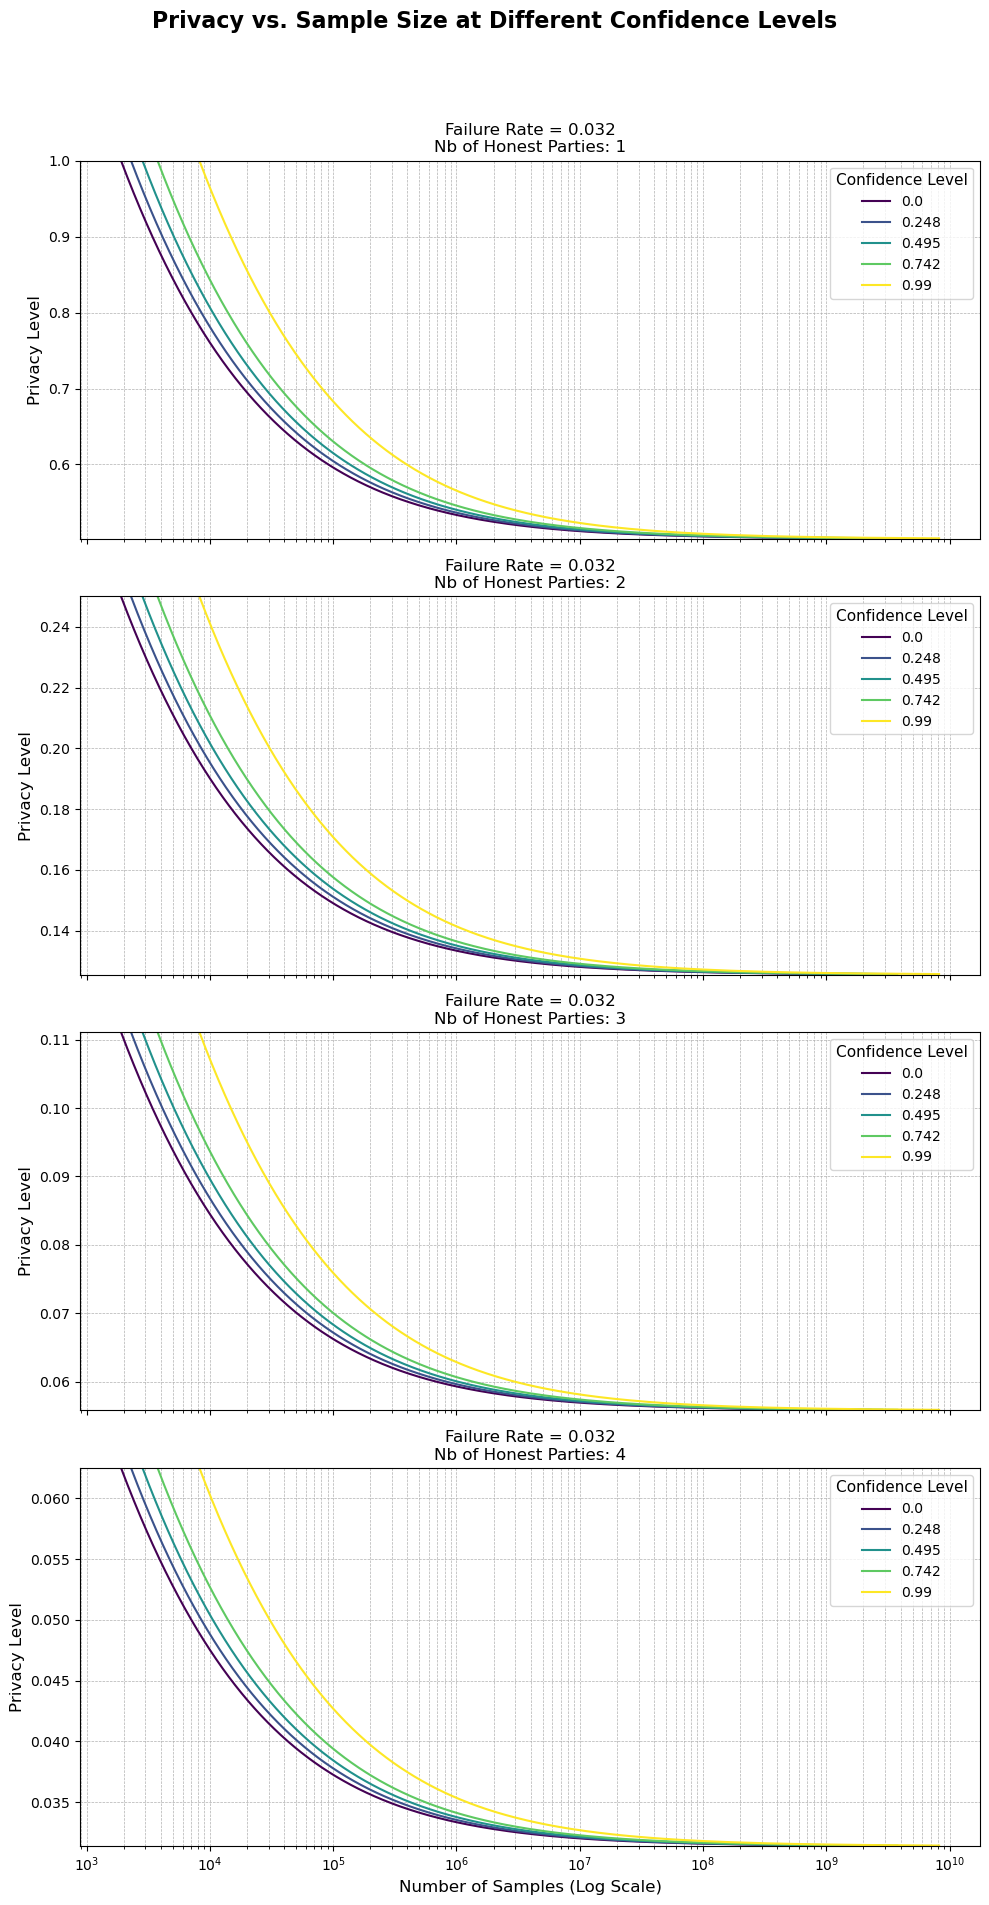

In [54]:
from tqdm import tqdm
import matplotlib.cm as cm
import os
import numpy as np
import matplotlib.pyplot as plt
import functools as ft

bell=(np.array([1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0])+np.array([0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1]))/np.sqrt(2)
rho = (np.array(np.outer(bell, np.transpose(np.conjugate(bell)))))
Confidence_level = np.linspace(0,0.99,num = 5)
sigma_x = np.array([[0,1],[1,0]])
sigma_z = np.matrix([[1,0],[0,-1]])
sigma_y = np.matrix([[0,-1j],[1j,0]])
Id = np.matrix([[1,0],[0,1]])
Id_8 = np.identity(16)

List_of_Meas = [ft.reduce(np.kron,(sigma_x,sigma_x,sigma_x,sigma_x)),-ft.reduce(np.kron,(sigma_y,sigma_y,sigma_x,sigma_x)),
                -ft.reduce(np.kron,(sigma_x,sigma_y,sigma_y,sigma_x)),-ft.reduce(np.kron,(sigma_x,sigma_x,sigma_y,sigma_y)),
                -ft.reduce(np.kron,(sigma_y,sigma_x,sigma_x,sigma_y))]
p = 0.937
color = cm.get_cmap('viridis', len(Confidence_level))
N = 4
n_H = np.arange(5)

fig, axes = plt.subplots(len(n_H) - 1, 1, figsize=(10, 20), sharex=True)
fig.suptitle('Privacy vs. Sample Size at Different Confidence Levels', fontsize=16, fontweight='bold')


for v in tqdm(range(len(n_H)-1)):
    ax = axes[v]  # Current subplot
    for j in range(len(Confidence_level)):
        P_min =[]
        N_test =[]
        Rho_Noise_White = p*rho + (1-p)*Id_8/16  
        F = (1 - 1/5*(np.sum([np.trace(Rho_Noise_White@List_of_Meas[i]) for i in range(len(List_of_Meas))])))/2
        F_min = np.linspace(0,1-2*N*F,num=1000)

        for i in range(len(F_min)):
            c = (N*(1-F_min[i]-2*N*F)/2)**2
            m = ((3/2)*(1-(np.log(1-Confidence_level[j])/np.log(N))))/c
            P_min.append((24/n_H[v+1]**2)*(np.sqrt(2*np.sqrt(c)/N + 2*N*F))/24)
            N_test.append(m*((N**4)*np.log(N)*8))
            # Plotting in the current subplot
        ax.plot(N_test, P_min, label=f'{np.round(Confidence_level[j], 3)}', color=color(j))


    # Customization for the current subplot
    ax.set_title(f'Failure Rate = {np.real(np.round(F, 3))}\nNb of Honest Parties: {n_H[v + 1]}', fontsize=12)
    ax.set_ylabel('Privacy Level', fontsize=12)
    ax.set_ylim(np.min(P_min), np.max(P_min))
    ax.set_xscale('log')
    ax.grid(True, which='both', linestyle='--', linewidth=0.5)
    ax.legend(title='Confidence Level', fontsize=10, loc='upper right', title_fontsize=11)

# General x-label for all subplots
plt.xlabel('Number of Samples (Log Scale)', fontsize=12)

# Adjust layout to prevent overlap
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()


/var/folders/lc/_rcknr0d06s21ps17qjmr02h0000gp/T/ipykernel_975/1667981816.py:20: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  color = cm.get_cmap('viridis', len(Confidence_level))
  0%|          | 0/4 [00:00<?, ?it/s]/var/folders/lc/_rcknr0d06s21ps17qjmr02h0000gp/T/ipykernel_975/1667981816.py:39: RuntimeWarning: divide by zero encountered in scalar divide
  m = ((3/2)*(1-(np.log(1-Confidence_level[j])/np.log(N))))/c
/var/folders/lc/_rcknr0d06s21ps17qjmr02h0000gp/T/ipykernel_975/1667981816.py:39: RuntimeWarning: invalid value encountered in scalar divide
  m = ((3/2)*(1-(np.log(1-Confidence_level[j])/np.log(N))))/c
/var/folders/lc/_rcknr0d06s21ps17qjmr02h0000gp/T/ipykernel_975/1667981816.py:41: RuntimeWarning: invalid value encountered in scalar multiply
  N_test.append(m*((N**4)*np.log(N)*8))
/Users/Copains123/anac

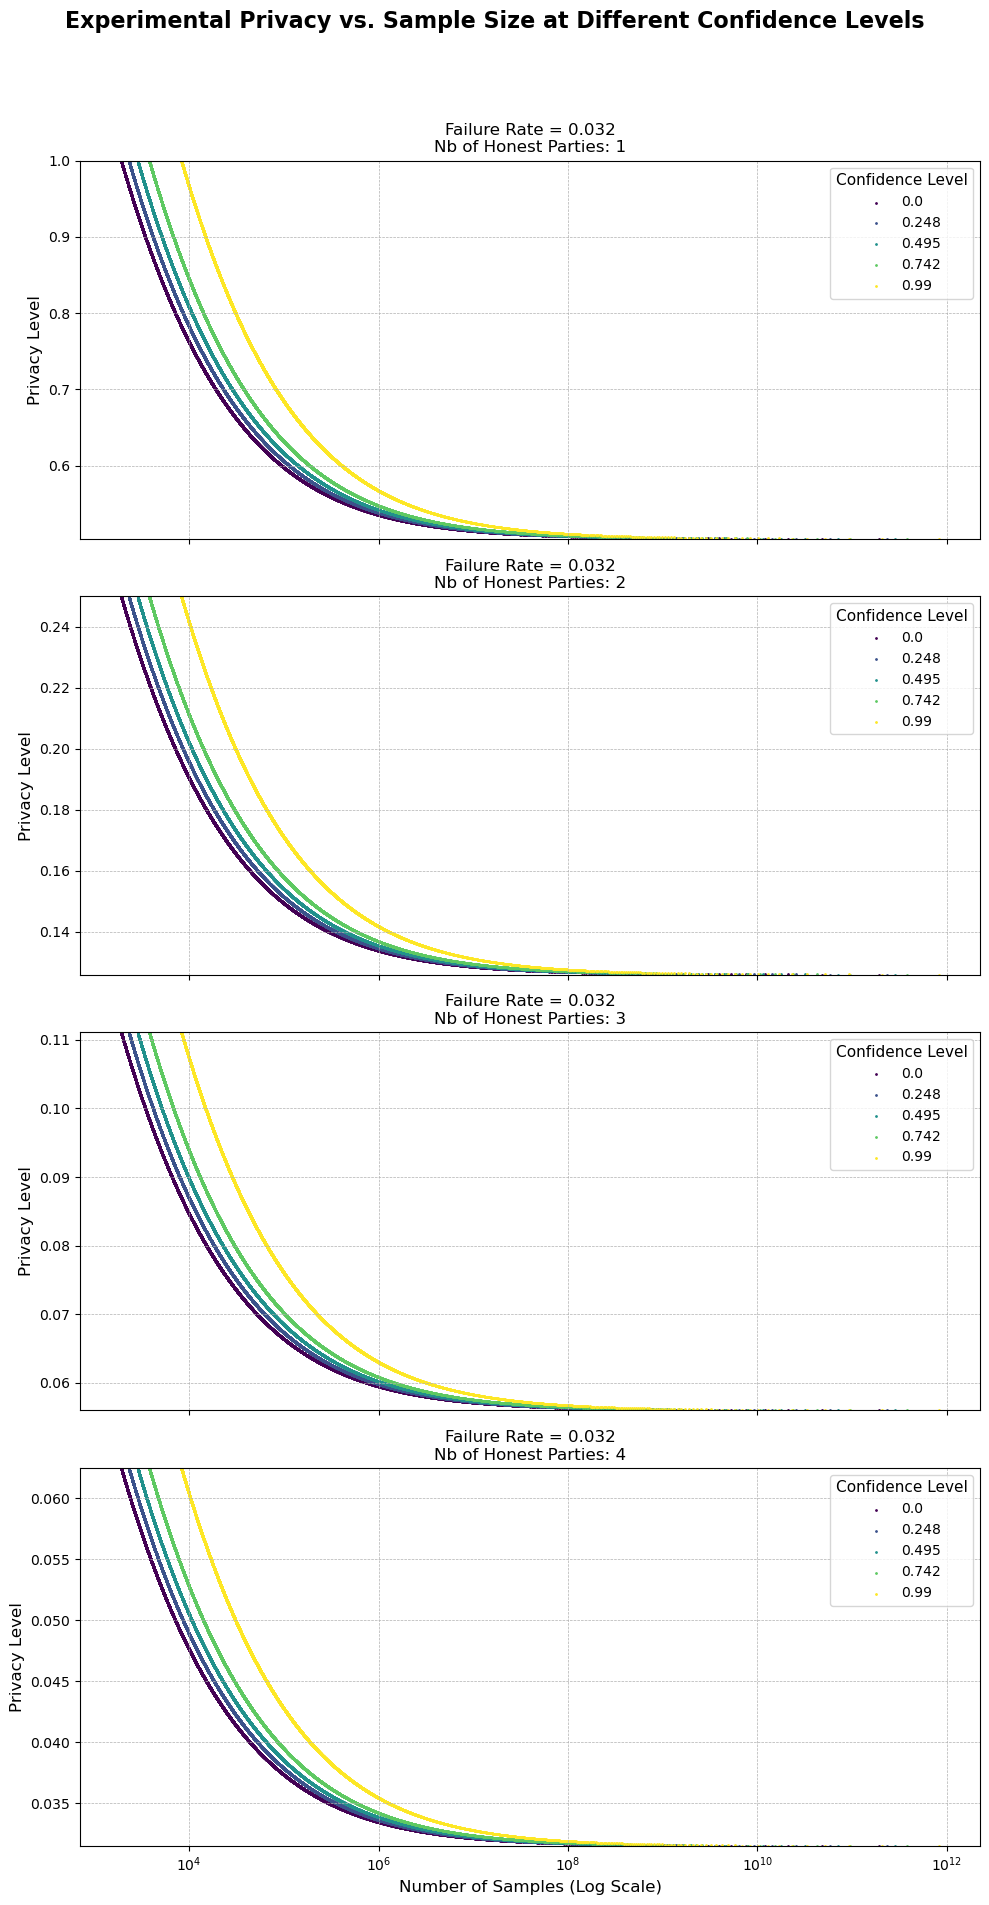

In [246]:
from tqdm import tqdm
import matplotlib.cm as cm
import os
import numpy as np
import matplotlib.pyplot as plt
import functools as ft

bell=(np.array([1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0])+np.array([0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1]))/np.sqrt(2)
rho = (np.array(np.outer(bell, np.transpose(np.conjugate(bell)))))
Confidence_level = np.linspace(0,0.99,num = 5)
sigma_x = np.array([[0,1],[1,0]])
sigma_z = np.matrix([[1,0],[0,-1]])
sigma_y = np.matrix([[0,-1j],[1j,0]])
Id = np.matrix([[1,0],[0,1]])
Id_8 = np.identity(16)

List_of_Meas = [ft.reduce(np.kron,(sigma_x,sigma_x,sigma_x,sigma_x)),-ft.reduce(np.kron,(sigma_y,sigma_y,sigma_x,sigma_x)),
                -ft.reduce(np.kron,(sigma_x,sigma_y,sigma_y,sigma_x)),-ft.reduce(np.kron,(sigma_x,sigma_x,sigma_y,sigma_y)),
                -ft.reduce(np.kron,(sigma_y,sigma_x,sigma_x,sigma_y))]
color = cm.get_cmap('viridis', len(Confidence_level))
N = 4
n_H = np.arange(5)

fig, axes = plt.subplots(len(n_H) - 1, 1, figsize=(10, 20), sharex=True)
fig.suptitle('Experimental Privacy vs. Sample Size at Different Confidence Levels', fontsize=16, fontweight='bold')


for v in tqdm(range(len(n_H)-1)):
    ax = axes[v]  # Current subplot
    for j in range(len(Confidence_level)):
        P_min =[]
        N_test =[]
        Rho_Exp = density_matrix 
        F = (1 - 1/5*(np.sum([np.trace(Rho_Exp@List_of_Meas[i]) for i in range(len(List_of_Meas))])))/2
        F_min = np.linspace(0,1-2*N*F,num=10000)

        for i in range(len(F_min)):
            c = (N*(1-F_min[i]-2*N*F)/2)**2
            m = ((3/2)*(1-(np.log(1-Confidence_level[j])/np.log(N))))/c
            P_min.append((24/n_H[v+1]**2)*(np.sqrt(2*np.sqrt(c)/N + 2*N*F))/24)
            N_test.append(m*((N**4)*np.log(N)*8))
            # Plotting in the current subplot
        ax.scatter(N_test, P_min, label=f'{np.round(Confidence_level[j], 3)}', color=color(j), s = 1)


    # Customization for the current subplot
    ax.set_title(f'Failure Rate = {np.real(np.round(F, 3))}\nNb of Honest Parties: {n_H[v + 1]}', fontsize=12)
    ax.set_ylabel('Privacy Level', fontsize=12)
    ax.set_ylim(np.min(P_min), np.max(P_min))
    ax.set_xscale('log')
    ax.grid(True, which='both', linestyle='--', linewidth=0.5)
    ax.legend(title='Confidence Level', fontsize=10, loc='upper right', title_fontsize=11)

# General x-label for all subplots
plt.xlabel('Number of Samples (Log Scale)', fontsize=12)

# Adjust layout to prevent overlap
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()


In [249]:
sigma_z@sigma_x

matrix([[ 0,  1],
        [-1,  0]])

/var/folders/lc/_rcknr0d06s21ps17qjmr02h0000gp/T/ipykernel_975/4266324024.py:22: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  color = cm.get_cmap('viridis', len(p))
  0%|          | 0/4 [00:00<?, ?it/s]/var/folders/lc/_rcknr0d06s21ps17qjmr02h0000gp/T/ipykernel_975/4266324024.py:44: RuntimeWarning: divide by zero encountered in scalar divide
  m = ((3/2)*(1-(np.log(1-0.01)/np.log(N))))/c
/var/folders/lc/_rcknr0d06s21ps17qjmr02h0000gp/T/ipykernel_975/4266324024.py:44: RuntimeWarning: invalid value encountered in scalar divide
  m = ((3/2)*(1-(np.log(1-0.01)/np.log(N))))/c
/var/folders/lc/_rcknr0d06s21ps17qjmr02h0000gp/T/ipykernel_975/4266324024.py:45: RuntimeWarning: invalid value encountered in scalar multiply
  N_test.append(m*((N**4)*np.log(N)*8))
/var/folders/lc/_rcknr0d06s21ps17qjmr02h0000gp/T/ipykernel_975/4266

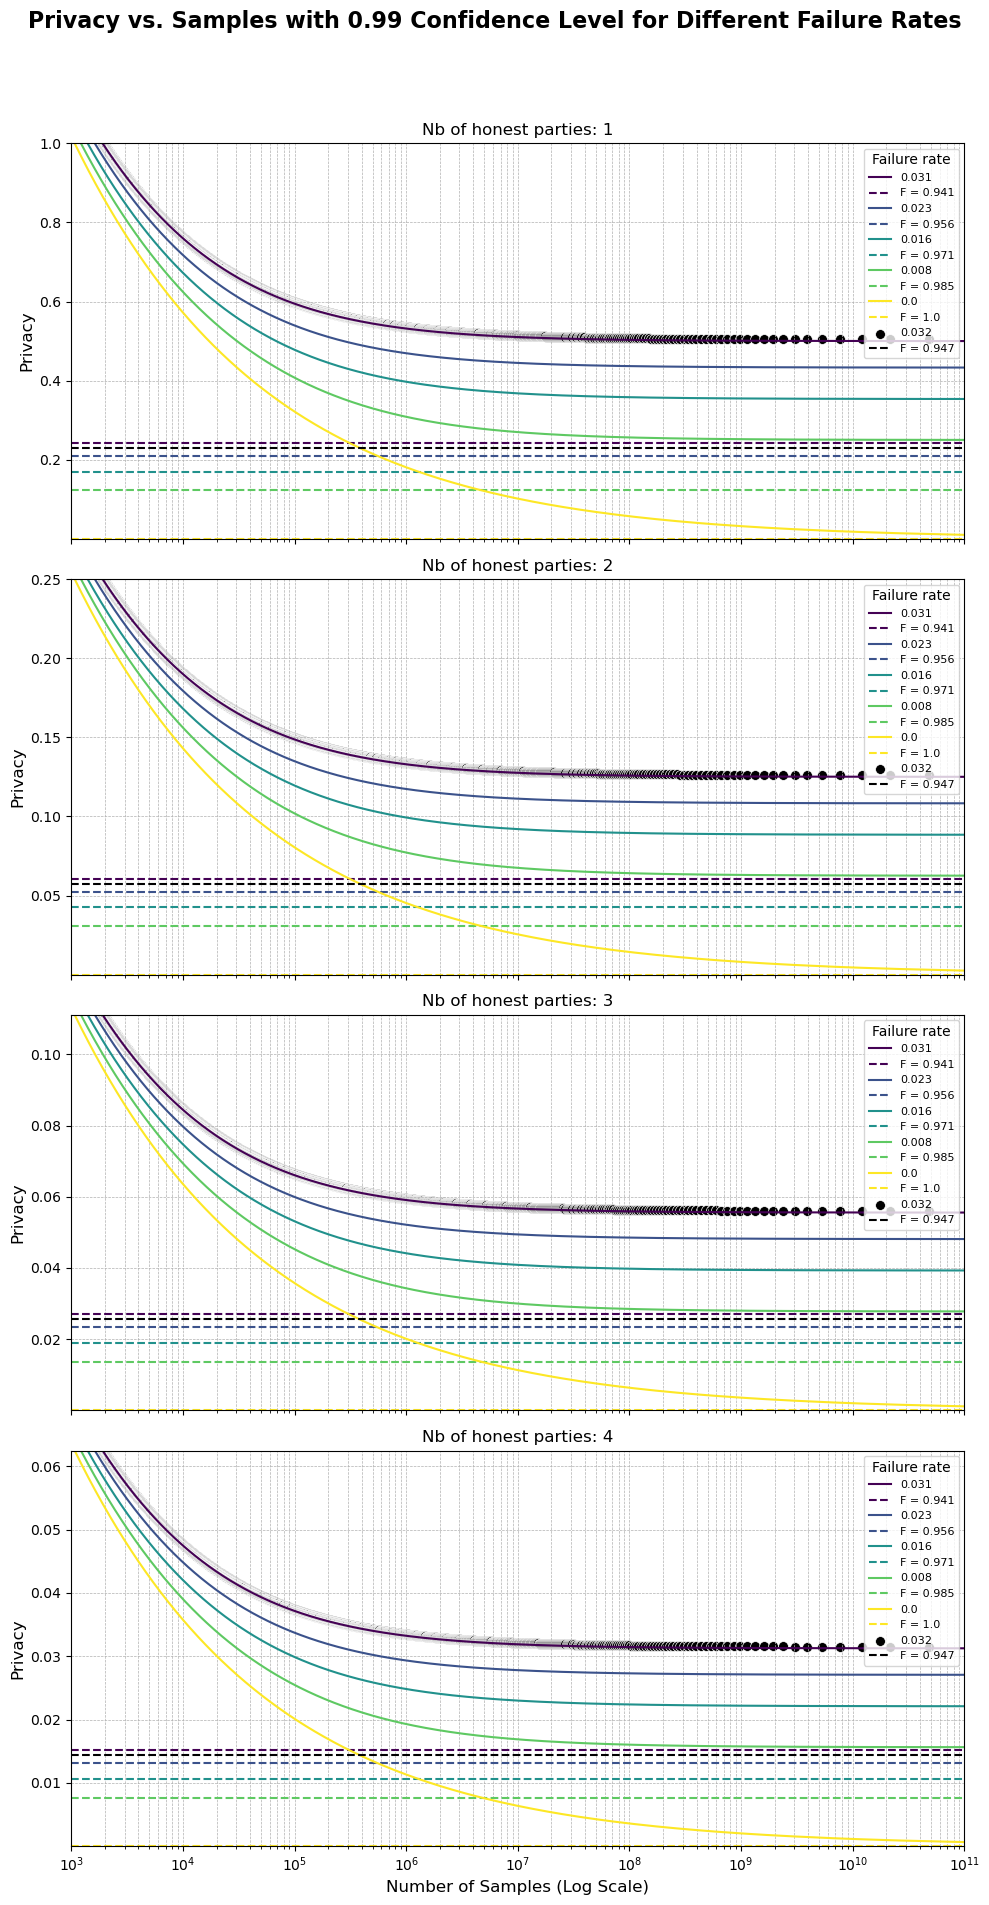

In [63]:
from tqdm import tqdm
import matplotlib.cm as cm
import os

import numpy as np
import matplotlib.pyplot as plt
import functools as ft

bell=(np.array([1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0])+np.array([0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1]))/np.sqrt(2)
rho = (np.array(np.outer(bell, np.transpose(np.conjugate(bell)))))
Confidence_level = np.linspace(1,0,num = 1000000)
sigma_x = np.array([[0,1],[1,0]])
sigma_z = np.matrix([[1,0],[0,-1]])
sigma_y = np.matrix([[0,-1j],[1j,0]])
Id = np.matrix([[1,0],[0,1]])
Id_8 = np.identity(16)

List_of_Meas = [ft.reduce(np.kron,(sigma_x,sigma_x,sigma_x,sigma_x)),-ft.reduce(np.kron,(sigma_y,sigma_y,sigma_x,sigma_x)),
                -ft.reduce(np.kron,(sigma_x,sigma_y,sigma_y,sigma_x)),-ft.reduce(np.kron,(sigma_x,sigma_x,sigma_y,sigma_y)),
                -ft.reduce(np.kron,(sigma_y,sigma_x,sigma_x,sigma_y))]
p = np.linspace(0.9375,1,num=5)
color = cm.get_cmap('viridis', len(p))
N =4

fig, axes = plt.subplots(len(n_H) - 1, 1, figsize=(10, 20), sharex=True)
fig.suptitle('Privacy vs. Samples with 0.99 Confidence Level for Different Failure Rates', fontsize=16, fontweight='bold')

fisher_EXP = []

for v in tqdm(range(len(n_H)-1)):
    ax = axes[v]
    for j in range(len(p)):
        P_min =[]
        N_test =[]
        Rho_Noise_White = p[j]*rho + (1-p[j])*Id_8/16  
        F = (1 - 1/5*(np.sum([np.trace(Rho_Noise_White@List_of_Meas[i]) for i in range(len(List_of_Meas))])))/2
        F_min = np.linspace(0,1-2*N*F,num=10000)
        Fidelity = np.round(qp_n.fid(Rho_Noise_White, rho), 3)
        P = (24/n_H[v+1]**2)*(np.sqrt(1-Fidelity))/24

        for i in range(len(F_min)):
            c = (N*(1-F_min[i]-8*F)/2)**2
            P_min.append((24/n_H[v+1]**2)*(np.sqrt(2*np.sqrt(c)/N + 2*N*F))/24)
            m = ((3/2)*(1-(np.log(1-0.01)/np.log(N))))/c
            N_test.append(m*((N**4)*np.log(N)*8))
            

        ax.plot(N_test, P_min, label=f'{np.max(np.round(np.real(F), 3))}', color=color(j))
        ax.axhline(P, label = f'F = {np.round(np.real(Fidelity),3)}',color = color(j), linestyle = '--')
    
    P_min_exp =[]
    N_test_exp =[]
    Rho_Exp = density_matrix
    F = (1 - 1/5*(np.sum([np.trace(density_matrix@List_of_Meas[i]) for i in range(len(List_of_Meas))])))/2
    F_min = np.linspace(0,1-2*N*F,num=10000)
    Fidelity = np.round(qp_n.fid(density_matrix, rho), 3)
    P = (24/n_H[v+1]**2)*(np.sqrt(1-Fidelity))/24
    
    for i in range(len(F_min)):
        c = (N*(1-F_min[i]-2*N*F)/2)**2
        P_min_exp.append((24/n_H[v+1]**2)*(np.sqrt(2*np.sqrt(c)/N + 2*N*F))/24)
        m = ((3/2)*(1-(np.log(1-0.01)/np.log(N))))/c
        N_test_exp.append(m*((N**4)*np.log(N)*8))
    
    fisher_EXP.append(np.min(P_min_exp)*np.array(fisher_Inv))
        
    ax.scatter(N_test_exp, P_min_exp, label=f'{np.max(np.round(np.real(F), 3))}', color='k', s=50, marker='o', edgecolor='w', linewidth=0.5)
    ax.axhline(P, label = f'F = {np.round(np.real(Fidelity),3)}',color = 'k', linestyle = '--')

    # Customization for the current subplot
    ax.set_title(f'Nb of honest parties: {n_H[v + 1]}', fontsize=12)
    ax.set_ylabel('Privacy', fontsize=12)
    ax.set_ylim(np.min(P_min), np.max(P_min))
    ax.set_xscale('log')
    ax.set_xlim(10 ** 3, 10 ** 11)
    ax.grid(True, which='both', linestyle='--', linewidth=0.5)
    ax.legend(title='Failure rate', fontsize=8, loc='upper right')

fisher_EXP.append(0.005653395160318045*np.array(fisher_Inv))
# General x-label for all subplots
plt.xlabel('Number of Samples (Log Scale)', fontsize=12)

# Adjust layout to prevent overlap
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

100%|██████████| 4/4 [00:00<00:00, 462.86it/s]


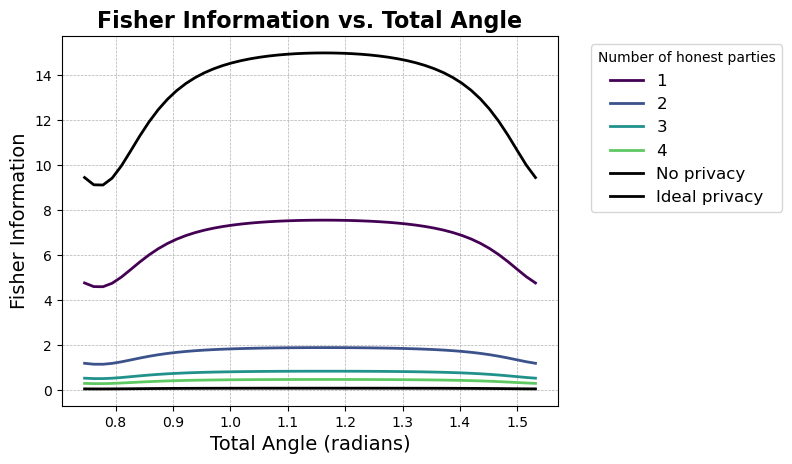

In [64]:
# Improved graph for better readability
for v in tqdm(range(len(n_H) - 1)):
    plt.plot(Total_angle, fisher_EXP[v], label=f'{n_H[v + 1]}', 
             linewidth=2, linestyle='-', marker='', color=plt.cm.viridis(v / (len(n_H) - 1)))

plt.plot(Total_angle, fisher_Inv, label= 'No privacy', 
             linewidth=2, linestyle='-', marker='', color='k')

plt.plot(Total_angle, fisher_EXP[-1], label= 'Ideal privacy', 
             linewidth=2, linestyle='-', marker='', color='k')

# Set the title and labels with increased font sizes
plt.title('Fisher Information vs. Total Angle', fontsize=16, fontweight='bold')
plt.xlabel('Total Angle (radians)', fontsize=14)
plt.ylabel('Fisher Information', fontsize=14)

# Move the legend to the upper right outside the plot and add a border
plt.legend(loc='upper left', bbox_to_anchor=(1.05, 1), fontsize=12, title='Number of honest parties', title_fontsize=10)

# Add gridlines to make the graph more readable
plt.grid(True, which='both', linestyle='--', linewidth=0.5)

# Set tight layout to prevent overlap

# Show the plot
plt.show()


In [ ]:
Rho_Exp = density_matrix

Z_1 = ft.reduce(np.kron, (sigma_z, Id, Id, Id)) -0.32164193* (
    ft.reduce(np.kron, (Id, sigma_z, Id, Id))
    + ft.reduce(np.kron, (Id, Id, sigma_z, Id))
    + ft.reduce(np.kron, (Id, Id, Id, sigma_z))
)
Z_2 = ft.reduce(np.kron, (Id, sigma_z, Id, Id)) -0.32164193 * (
    ft.reduce(np.kron, (sigma_z, Id, Id, Id))
    + ft.reduce(np.kron, (Id, Id, sigma_z, Id))
    + ft.reduce(np.kron, (Id, Id, Id, sigma_z))
)
Z_3 = ft.reduce(np.kron, (Id, Id, sigma_z, Id)) -0.32164193* (
    ft.reduce(np.kron, (sigma_z, Id, Id, Id))
    + ft.reduce(np.kron, (Id, sigma_z, Id, Id))
    + ft.reduce(np.kron, (Id, Id, Id, sigma_z))
)

Z_4 = ft.reduce(np.kron, (Id, Id, Id, sigma_z)) -0.32164193 * (
    ft.reduce(np.kron, (sigma_z, Id, Id, Id))
    + ft.reduce(np.kron, (Id, Id, sigma_z, Id))
    + ft.reduce(np.kron, (Id, sigma_z, Id, Id)))

(1/16)*(np.trace(Rho_Exp@(Z_4@Z_4)) - (np.trace(Rho_Exp @ Z_4))**2)

In [71]:
import functools as ft
import numpy as np
from scipy.optimize import differential_evolution

# Supposons que `sigma_z`, `Id`, et `Rho_Exp` soient définis correctement
# Exemple de matrices (à adapter à votre problème)
sigma_z = np.array([[1, 0], [0, -1]])  # Pauli-Z
Id = np.eye(2)  # Matrice identité 2x2
# Supposons une matrice densité 16x16 appropriée
plus = (1/16)*np.ones((16,16))
Rho_Exp = plus

# Fonction à minimiser
def Fish(X):
    Z_4 = ft.reduce(np.kron, (Id, Id, Id, sigma_z)) + X * (
        ft.reduce(np.kron, (sigma_z, Id, Id, Id))
        + ft.reduce(np.kron, (Id, Id, sigma_z, Id))
        + ft.reduce(np.kron, (Id, sigma_z, Id, Id))
    )
    
    trace_Z4_squared = np.trace(Rho_Exp @ (Z_4 @ Z_4))
    trace_Z4 = np.trace(Rho_Exp @ Z_4)
    
    result = trace_Z4_squared - trace_Z4**2
    return result

# Utilisation de differential evolution pour minimiser la fonction `Fish`
bounds = [(-10, 10)]  # Vous pouvez ajuster les bornes en fonction du domaine possible de X

result = differential_evolution(Fish, bounds)

print("Minimum trouvé :", result.x)
print("Valeur minimale de la fonction :", result.fun)

Minimum trouvé : [-4.20858886e-09]
Valeur minimale de la fonction : 1.0


In [245]:

import functools as ft
import numpy as np
from scipy.optimize import minimize
import itertools as iter
import scipy.linalg as lp


Rho_Exp = density_matrix

bell=(np.array([1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0])+np.array([0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1]))/np.sqrt(2)
rho = ((np.outer(bell, np.transpose(np.conjugate(bell)))))
plus = (1/16)*np.ones((16,16))

States = {'Rho_Exp' : density_matrix,'GHZ' : np.complex128((np.outer(bell, np.transpose(np.conjugate(bell))))),'++++':(1/16)*np.ones((16,16))}
Max_test = []
for z in States.values():

    eigenvalues, eigenvectors = lp.eigh(z)

    rho1 = np.zeros((len(eigenvalues),len(eigenvalues)))

    for i in range(len(eigenvalues)):
        rho1 = rho1 + eigenvalues[i]*(np.outer(np.transpose(np.conjugate((np.matrix(eigenvectors[:,i])))),np.matrix(eigenvectors[:,i])))

    Test = []

    # Supposons que `sigma_z`, `Id`, et `Rho_Exp` soient définis correctement
    # Exemple de matrices (à adapter à votre problème)
    sigma_z = np.array([[1, 0], [0, -1]])  # Pauli-Z
    Id = np.eye(2)  # Matrice identité 2x2
    # Supposons une matrice densité 16x16 appropriée


    Zj = [ft.reduce(np.kron, (sigma_z, Id, Id, Id)),ft.reduce(np.kron, (Id, sigma_z, Id, Id)),ft.reduce(np.kron, (Id, Id,sigma_z, Id)),ft.reduce(np.kron, (Id,  Id, Id,sigma_z))]
    Zk = [(
            ft.reduce(np.kron, (Id, Id, Id, sigma_z))
            + ft.reduce(np.kron, (Id, Id, sigma_z, Id))
            + ft.reduce(np.kron, (Id, sigma_z, Id, Id))
        ),(
            ft.reduce(np.kron, (sigma_z, Id, Id, Id))
            + ft.reduce(np.kron, (Id, Id, sigma_z, Id))
            + ft.reduce(np.kron, (Id, Id, Id, sigma_z))
        ),(
            ft.reduce(np.kron, (sigma_z, Id, Id, Id))
            + ft.reduce(np.kron, (Id,sigma_z, Id, Id))
            + ft.reduce(np.kron, (Id, Id, Id,sigma_z))
        ),(
            ft.reduce(np.kron, (sigma_z, Id, Id, Id))
            + ft.reduce(np.kron, (Id, Id, sigma_z, Id))
            + ft.reduce(np.kron, (Id, sigma_z, Id, Id))
        )]

    def Eps(X,Zj,Zk):
        epsilon=0
        for i in range(len(eigenvalues)):
            for j in range(len(eigenvalues)):
                if eigenvalues[j]+eigenvalues[i] != 0:
                    epsilon = epsilon + ((eigenvalues[j]-eigenvalues[i])**2)/(eigenvalues[j]+eigenvalues[i])*abs(
                        (eigenvectors[:,j])@Zj@np.transpose(np.conjugate(((eigenvectors[:,i]))))
                        + X * (eigenvectors[:,j])@(Zk)@(np.transpose(np.conjugate(((eigenvectors[:,i]))))))**2
        epsilon = epsilon/(2)
        return(np.real(epsilon))

    Test = []
    for K,L in zip(Zj,Zk):
        bounds = 0 # Vous pouvez ajuster les bornes en fonction du domaine possible de X

        result = minimize(Eps,bounds,args=(K,L))

        Test.append(result.fun)
    Max_test.append(np.max(Test))
    
print('Privacy',', '.join(States),'=',Max_test)


Privacy Rho_Exp, GHZ, ++++ = [0.08357934482211737, 5.121946520780268e-16, 1.0000000000000004]


In [76]:
import functools as ft
import numpy as np
from scipy.optimize import minimize
import itertools as iter
import scipy.linalg as lp
import scipy.special as ss
import matplotlib.pyplot as plt

bell=(np.array([1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0])+np.array([0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1]))/np.sqrt(2)
rho = ((np.outer(bell, np.transpose(np.conjugate(bell)))))
Id_16 = np.identity(16)

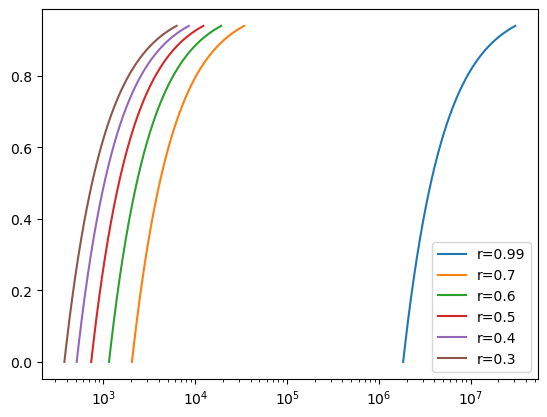

In [151]:
############################# NEW PROTOCOL ##############################

lamb= [1/2]
r = [0.99,0.7,0.6,0.5,0.4,0.3]
Infidelity = np.linspace(0.06,0.9999,num = 1000)
delta = 0.01

for j in range(len(lamb)):
    nu = 1-lamb[j]
    for i in range(len(r)):
        N = (((np.log(1/delta))+4*lamb[j]*nu**2)/(Infidelity))*(((lamb[j] * np.sqrt(2 * (nu)) + 1)/(lamb[j] * (nu) * (1 - r[i])))**2)
        plt.plot(N,1-Infidelity,label = f'r={r[i]}')
        plt.legend()
        plt.xscale('log')
    plt.show()



/var/folders/lc/_rcknr0d06s21ps17qjmr02h0000gp/T/ipykernel_18077/2236063595.py:10: RuntimeWarning: divide by zero encountered in divide
  N = (((np.log(1/delta))+4*lamb[j]*nu**2)/(Infidelity))*(((lamb[j] * np.sqrt(2 * (nu)) + 1)/(lamb[j] * (nu) * (1 - r[i])))**2)
/var/folders/lc/_rcknr0d06s21ps17qjmr02h0000gp/T/ipykernel_18077/2236063595.py:11: RuntimeWarning: divide by zero encountered in divide
  plt.plot(1/Infidelity,N/10**5,label = f'r={r[i]}')


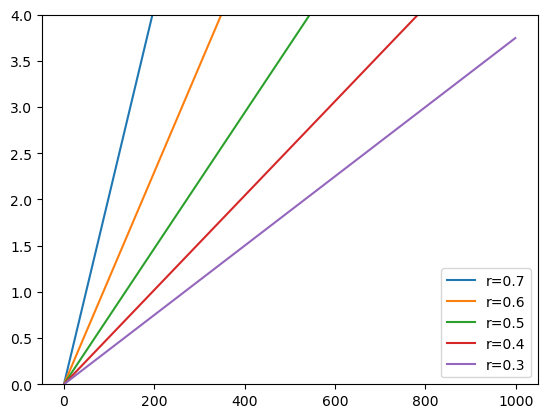

In [179]:
lamb= [1/2]
r = [0.7,0.6,0.5,0.4,0.3]
Infidelity_t = abs(np.trace(Rho_Exp@(ft.reduce(np.kron,(sigma_z,sigma_z,sigma_z,sigma_z)))) - np.trace(rho@(ft.reduce(np.kron,(sigma_z,sigma_z,sigma_z,sigma_z)))))**2
Infidelity = np.linspace(0,0.999999999999,num = 1000)
delta = 0.01

for j in range(len(lamb)):
    nu = 1-lamb[j]
    for i in range(len(r)):
            N = (((np.log(1/delta))+4*lamb[j]*nu**2)/(Infidelity))*(((lamb[j] * np.sqrt(2 * (nu)) + 1)/(lamb[j] * (nu) * (1 - r[i])))**2)
            plt.plot(1/Infidelity,N/10**5,label = f'r={r[i]}')
            plt.legend()
            plt.ylim(0,4)
    plt.show()


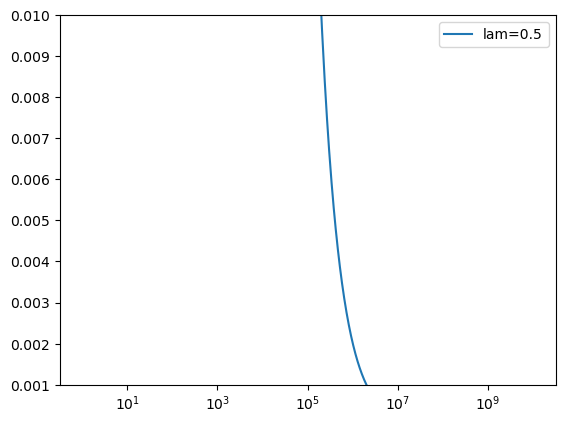

In [142]:
lamb= [1/2]
r = [0.75]
Infidelity_t = abs(np.trace(Rho_Exp@(ft.reduce(np.kron,(sigma_z,sigma_z,sigma_z,sigma_z)))) - np.trace(rho@(ft.reduce(np.kron,(sigma_z,sigma_z,sigma_z,sigma_z)))))**2
N = np.linspace(1,10000000000,num = 1000000)
delta = 0.05
Infidelity_t = 1 - np.trace(Rho_Exp@rho)

for j in range(len(r)):
    nu = 1-lamb[j]
    for i in range(len(lamb)):
        Infidelity = (((np.log(1/delta))+4*lamb[i]*nu**2)/N)*(((lamb[i] * np.sqrt(2 * (nu)) + 1)/(lamb[i] * (nu) * (1 - r[j])))**2)
        plt.plot(N,Infidelity,label = f'lam={lamb[i]}')
plt.legend()
plt.xscale('log')
plt.ylim(0.001,0.01)
plt.show()


In [143]:
Infidelity_t

(0.05322033308478802+1.734723475976807e-18j)

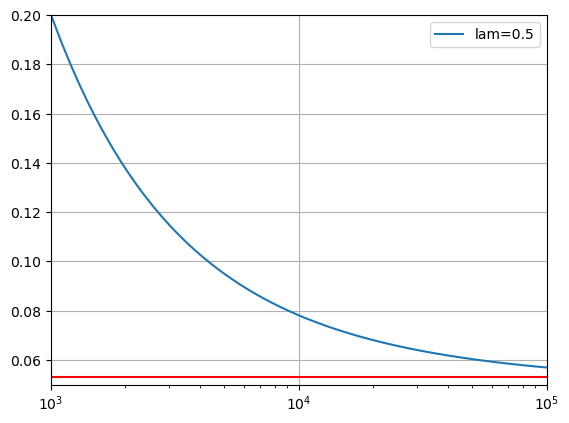

In [305]:
lamb= 1/2
N = np.linspace(1,100000,num = 1000)
delta = 0.01
Infidelity_t = 1 - np.trace(Rho_Exp@rho)
s = (1-0.975)*2
Infidelity_t = 1 - np.trace(Rho_Exp@rho)



nu = 1-lamb
Infidelity = s + (1/(nu*lamb))*(np.sqrt(s*np.log(1/delta)/N)+(np.log(1/delta)/(2*(nu**2)*(lamb*N)))+2/(lamb*N))
plt.plot(N,Infidelity,label = f'lam={lamb}')
plt.axhline(Infidelity_t,color='r')
plt.legend()
plt.xscale('log')
plt.ylim(s,0.2)
plt.xlim(1000,100000)
plt.grid()
plt.show()


In [ ]:
qpef.N(0.08,0.06,1/2,1/2,0.01)


epsilon_tau = 0.06
nu = lamb = 1/2
delta = np.linspace(0.01,0.05,num = 5)
epsilon = np.linspace(0.5,0.06,num = 1000)


for i in range(len(delta)):
    N = qpef.N(epsilon,epsilon_tau,nu,lamb,delta[i])
    plt.plot(N,epsilon)

plt.xscale('log')
plt.grid()
plt.xlim(10**4,10**6)
plt.ylim(1-0.90,1-0.935)

In [ ]:
epsilon_tau = 0.06
nu = lamb = 1/2
delta = np.linspace(0,0.05,num = 5000000)
epsilon = np.linspace(0.1,0.07,num = 4)


for i in range(len(epsilon)):
    N = qpef.N(epsilon[i],epsilon_tau,nu,lamb,delta)
    plt.plot(N,1-delta)

plt.xscale('log')
plt.grid()

In [ ]:
nu = lamb = 1/2
delta = np.linspace(0.01,0.05,num = 5)
epsilon = np.linspace(0.5,0.06,num = 1000)


for i in range(len(delta)):
    N = qpef.N(epsilon,r,nu,lamb,delta)
    plt.plot(N,epsilon)

plt.xscale('log')
plt.grid()
plt.xlim(10**4,10**6)
plt.ylim(1-0.90,1-0.935)
